## Import Libraries

In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage import transform
import numpy as np
import cv2
import os
import glob
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import imageio

##  Feature Extraction

In [2]:
def image_to_feature_vector(image, size=(80, 80)):
    image = transform.resize(image, size)
    return image.flatten()

In [3]:
def extract_color_histogram(image, bins=(4, 4, 4)):
    image = cv2.resize(image, (80, 80))
    # extract a 3D color histogram from the HSV color space using
    # the supplied number of `bins` per channel
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
                        [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    # return the flattened histogram as the feature vector
    return hist.flatten()

In [4]:
from skimage.feature import hog
def HOG(image):
    img = transform.resize(image, (80, 80))
    fd = hog(image, 
             orientations=8, 
             pixels_per_cell=(8,8),
             cells_per_block=(3,3), 
             block_norm='L2-Hys', 
             visualize=False, 
             transform_sqrt=False,
             channel_axis=-1)
    return fd

In [5]:
from scipy.fftpack import dct, idct
from skimage.color import rgb2gray
def DCT_2D(image, num_coeffs=100, width=80): 
    # implement 2D DCT
    def dct2(a):
        return dct(dct(a.T, norm='ortho').T, norm='ortho')
    image = rgb2gray(image) 
    image = transform.resize(image, (width, width))
    imageF = dct2(image)
    zigzag = np.concatenate([np.diagonal(imageF[::-1,:], i)[::(2*(i % 2)-1)] for i in range(1-imageF.shape[0], imageF.shape[0])])
    return zigzag[:num_coeffs]

In [6]:
from skimage.feature import graycomatrix, graycoprops
def co_occurence(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    features = []
    for j in [1, 3, 5, 7]:
        for k in [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]:
            GLCM_properties = []
            GLCM = graycomatrix(image, [j], [k])
            GLCM_Energy = graycoprops(GLCM, 'energy')
            GLCM_properties.append(np.squeeze(GLCM_Energy))
            GLCM_corr = graycoprops(GLCM, 'correlation')
            GLCM_properties.append(np.squeeze(GLCM_corr))
            GLCM_diss = graycoprops(GLCM, 'dissimilarity')
            GLCM_properties.append(np.squeeze(GLCM_diss))
            GLCM_hom = graycoprops(GLCM, 'homogeneity')
            GLCM_properties.append(np.squeeze(GLCM_hom))       
            GLCM_contr = graycoprops(GLCM, 'contrast')
            GLCM_properties.append(np.squeeze(GLCM_contr))
            features += GLCM_properties
    return list(features)

In [7]:
images = []
labels = []

In [8]:
pathName = "/kaggle/input/coreldb-10cls/CorelDB"
i = 0
for dirName, subdirList, fileList in os.walk(pathName):
    for fileName in fileList:
        base, extension = os.path.splitext(fileName)
        if extension == '.jpg' or extension == '.JPG' or extension == '.png' or extension == '.PNG':

            imagePath = f"{dirName}/{fileName}"
            image = imageio.imread(imagePath)
            images.append(image)
            
            label = os.path.basename(dirName)
            labels.append(label)

            if i > 0 and i % 1000 == 0:
                print(f"{i}/10800")

            i += 1

1000/10800
2000/10800
3000/10800
4000/10800
5000/10800
6000/10800
7000/10800
8000/10800
9000/10800
10000/10800


In [9]:
feature_extraction_method = extract_color_histogram
X = np.array(list(map(feature_extraction_method, images)))
print(X.shape)

le = LabelEncoder()
y = le.fit_transform(labels)
print(y.shape)

(10800, 64)
(10800,)


## Data Preprocessing

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8640, 64)
(2160, 64)
(8640,)
(2160,)


## PCA

(8640, 10)
(2160, 10)


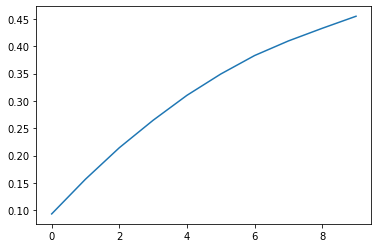

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)
y_pca_train = y_train
y_pca_test = y_test

print(X_pca_train.shape)
print(X_pca_test.shape)

explained_variance = pca.explained_variance_
plt.plot(np.cumsum((pca.explained_variance_)))
plt.show()

##  Classification

In [13]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [1, 10, 20, 30],
            'kernel': ['sigmoid', 'rbf', 'linear', 'poly']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1, 5, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [1, 5, 10, 50, 100]
        }
    },
    'KNN' : {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [1 ,3, 5, 7, 9, 11, 13],
            'metric': ["minkowski", "euclidean", "manhattan", "chebyshev", "cosine", "hamming", "canberra", "braycurtis"]
        }
    }
    
}

In [14]:
from sklearn.model_selection import GridSearchCV
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=3, return_train_score=True, verbose=3)
    clf.fit(X_pca_train, y_pca_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END C=1, kernel=sigmoid;, score=(train=0.348, test=0.344) total time=   4.0s
[CV 2/3] END C=1, kernel=sigmoid;, score=(train=0.344, test=0.342) total time=   4.5s
[CV 3/3] END C=1, kernel=sigmoid;, score=(train=0.345, test=0.334) total time=   4.0s
[CV 1/3] END C=1, kernel=rbf;, score=(train=0.373, test=0.360) total time=   3.5s
[CV 2/3] END C=1, kernel=rbf;, score=(train=0.356, test=0.365) total time=   3.6s
[CV 3/3] END C=1, kernel=rbf;, score=(train=0.366, test=0.351) total time=   3.4s
[CV 1/3] END C=1, kernel=linear;, score=(train=0.372, test=0.361) total time=   2.1s
[CV 2/3] END C=1, kernel=linear;, score=(train=0.357, test=0.372) total time=   2.1s
[CV 3/3] END C=1, kernel=linear;, score=(train=0.366, test=0.350) total time=   2.0s
[CV 1/3] END C=1, kernel=poly;, score=(train=0.245, test=0.245) total time=   2.4s
[CV 2/3] END C=1, kernel=poly;, score=(train=0.245, test=0.245) total time=   2.4s
[CV 3/3] END C

In [15]:
df_score = pd.DataFrame(scores,columns=['model','best_score','best_params'])
print(df_score)

                 model  best_score                                 best_params
0                  svm    0.422222                  {'C': 30, 'kernel': 'rbf'}
1        random_forest    0.475579                       {'n_estimators': 400}
2  logistic_regression    0.363194                                  {'C': 100}
3                  KNN    0.443171  {'metric': 'minkowski', 'n_neighbors': 11}


In [20]:
# SVM
C = 30
kernel = "rbf"

svm_clf = svm.SVC(kernel=kernel, C=C, gamma='auto')
svm_clf.fit(X_train, y_train)

svm_clf_score_train = svm_clf.score(X_train, y_train)
svm_clf_score_test = svm_clf.score(X_test, y_test)

print(f"Train accuracy - SVM: {svm_clf_score_train}")
print(f"Test accuracy - SVM: {svm_clf_score_test}")

Train accuracy - SVM: 0.44016203703703705
Test accuracy - SVM: 0.4305555555555556


In [21]:
# Random Forest
n_estimators = 400

rf_clf = RandomForestClassifier(n_estimators=n_estimators)
rf_clf.fit(X_train, y_train)

rf_clf_score_train = rf_clf.score(X_train, y_train)
rf_clf_score_test = rf_clf.score(X_test, y_test)

print(f"Train accuracy - Random Forest: {rf_clf_score_train}")
print(f"Test accuracy - Random Forest: {rf_clf_score_test}")

Train accuracy - Random Forest: 1.0
Test accuracy - Random Forest: 0.5976851851851852


In [22]:
# Logistic Regression
C = 100

lr_clf = LogisticRegression(solver='liblinear', multi_class='auto', C=C)
lr_clf.fit(X_train, y_train)

lr_clf_score_train = lr_clf.score(X_train, y_train)
lr_clf_score_test = lr_clf.score(X_test, y_test)

print(f"Train accuracy - Logistic Regression: {lr_clf_score_train}")
print(f"Test accuracy - Logistic Regression: {lr_clf_score_test}")

Train accuracy - Logistic Regression: 0.440625
Test accuracy - Logistic Regression: 0.4324074074074074


In [23]:
# k-NN
metric = "minkowski"
n_neighbors = 11

knn_clf = KNeighborsClassifier(metric=metric, n_neighbors=n_neighbors)
knn_clf.fit(X_train, y_train)

knn_clf_score_train = knn_clf.score(X_train, y_train)
knn_clf_score_test = knn_clf.score(X_test, y_test)

print(f"Train accuracy - k-NN: {knn_clf_score_train}")
print(f"Test accuracy - k-NN: {knn_clf_score_test}")

Train accuracy - k-NN: 0.5508101851851852
Test accuracy - k-NN: 0.47824074074074074
